## Lab 4: Functional Programming

So far in this course, all our Jupyter notebook programming has avoided the use of any user defined functions, instead just writing our code line by line, cell by cell as we try to analyze and manipulate our data.

There is nothing wrong with this approach, especially in a data science perspective, but there are two potential issues we've mentioned previously.

1. Redundant code
Say you write some code using pandas,numpy or whatever that performs some useful transformation of your data. If you ever wanted to apply the same transformation to a different part of your data later in your notebook, you would need to rewrite the exact same code, creating extra work.

2. Linear variable referencing
The biggest pitfall with programming in a notebook environment is that any user defined variables, including dataframes, are entirely defined by whatever cells you last run. Functions and other aspects of modular programming can help avoid this.


The goal for this lab is simple: take some of the code we previously wrote in Lab 3 and rewrite into functions that are applicable anywhere.

**Starting off with loading the dataset and applying some of the same transformations we made last week. Rest of the notebook is just helpful examples and explanation, Excercise 1 is found all the way at the bottom.**

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
%matplotlib inline

### Babynames Dataset

In [17]:
import requests
from pathlib import Path

def fetch_and_cache(data_url, file, data_dir="data", force=False):
    """
    Download and cache a URL and return the file object.
    
    data_url: The web address to download.
    file: The file in which to save the results.
    data_dir: (default="data") The location to save the data.
    force: If true, the file is always re-downloaded. 
    
    return: The pathlib.Path to the file.
    """
    data_dir = Path(data_dir)
    data_dir.mkdir(exist_ok=True)
    file_path = data_dir/Path(file)
    if force and file_path.exists():
        file_path.unlink()
    if force or not file_path.exists():
        print('Downloading...', end=' ')
        resp = requests.get(data_url)
        with file_path.open('wb') as f:
            f.write(resp.content)
        print('Done!')
    else:
        import time 
        created = time.ctime(file_path.stat().st_ctime)
        print("Using cached version downloaded at", created)
    return file_path

In [18]:
data_url = 'https://www.ssa.gov/oact/babynames/state/namesbystate.zip'
namesbystate_path = fetch_and_cache(data_url, 'namesbystate.zip')

Using cached version downloaded at Thu Feb  8 12:33:32 2024


In [19]:
import zipfile
zf = zipfile.ZipFile(namesbystate_path, 'r')

column_labels = ['State', 'Sex', 'Year', 'Name', 'Count']

def load_dataframe_from_zip(zf, f):
    with zf.open(f) as fh: 
        return pd.read_csv(fh, header=None, names=column_labels)

states = [
    load_dataframe_from_zip(zf, f)
    for f in sorted(zf.filelist, key=lambda x:x.filename) 
    if f.filename.endswith('.TXT')
]

babynames = states[0]
for state_df in states[1:]:
    babynames = pd.concat([babynames, state_df])
babynames = babynames.reset_index().iloc[:, 1:]

In [20]:
babynames.head()

,State,Sex,Year,Name,Count
0,AK,F,1910,Mary,14
1,AK,F,1910,Annie,12
2,AK,F,1910,Anna,10
3,AK,F,1910,Margaret,8
4,AK,F,1910,Helen,7


In [21]:
 babynames['Name'].value_counts()

James        7465
Leslie       7428
Lee          7344
John         7271
Robert       7225
             ... 
Elona           1
Jamill          1
Ekamveer        1
Yarisbeth       1
Zondra          1
Name: Name, Length: 32722, dtype: int64

In [22]:
James = babynames[babynames['Name'] == 'James']
James

,State,Sex,Year,Name,Count
15340,AK,M,1910,James,7
15348,AK,M,1911,James,8
15358,AK,M,1912,James,5
15362,AK,M,1913,James,8
15365,AK,M,1914,James,12
...,...,...,...,...,...
6407417,WY,M,2018,James,13
6407535,WY,M,2019,James,20
6407683,WY,M,2020,James,15
6407801,WY,M,2021,James,21


In [23]:
James = James.groupby(["Year"])[["Count"]].agg(sum).reset_index()
James

,Year,Count
0,1910,9202
1,1911,9981
2,1912,17683
3,1913,20881
4,1914,26326
...,...,...
108,2018,13641
109,2019,13198
110,2020,12390
111,2021,12452


In [24]:
Leslie = babynames[babynames['Name'] == 'Leslie'].groupby(["Year"])[["Count"]].agg(sum).reset_index()
Lee = babynames[babynames['Name'] == 'Lee'].groupby(["Year"])[["Count"]].agg(sum).reset_index()

### Last Week 

During our last section, we demonstrated how we can extract meaninfull and specific data from a larger dataset, and then visualized the results in a complicated format using subplots and other plotting functionality.

However, if you take a look at the above two cells where we create our three 'names' dataframes, you will notice some redundancy; each dataframe is created with the exact same pandas methods apart from the 'Name' boolean index. This is the perfect case to utilize functions, or modular programming.

My hope is that everyone is at least somewhat familir with Python functions, but here are some basic examples

#### Super basic math example

In [25]:
def square_value(x):
    new_value = x**2
    return(x**2)

square_value(5)

25

#### Basic example with plotting functions

Lets create a function that does a scatter + linear regression plot for some arbitrary x and y data.

()

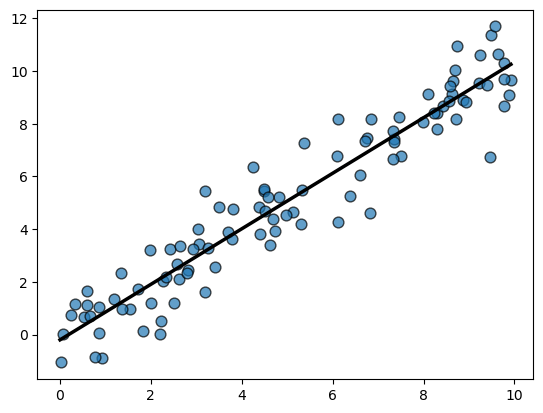

In [26]:
def plot_linear(x,y):
    # Initialize layout


    # Add scatterplot
    plt.scatter(x, y, s=60, alpha=0.7, edgecolors="k")

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    b, a = np.polyfit(x, y, deg=1)

    # Create sequence of 100 numbers from 0 to the maximum x value 
    xseq = np.linspace(0, np.max(x), num=100)

    # Plot regression line
    plt.plot(xseq, a + b * xseq, color="k", lw=2.5);
    return()

# Generate data
rng = np.random.default_rng(1234)
x_test = rng.uniform(0, 10, size=100)
y_test = x_test + rng.normal(size=100)

plot_linear(x_test,y_test)


Notice that in this example, the return value is empty. This is because our goal in this case is already accomplished within the function: generating and visualizing the plot.

#### Applying functions to Pandas dataframes

We already wrote code previously that creates a specific 'Name' dataframe from the full babynames dataset. It is fairly straightforward to take that code and rewrite it into a function that will create a new dataframe for any given name.

In [29]:
def generate_name_df(name):
    name_df = babynames[babynames['Name'] == name].groupby(["Year"])[["Count"]].agg(sum).reset_index()
    return(name_df)

Anna = generate_name_df('Anna') ### careful about function input, need a string in this case
Anna

,Year,Count
0,1910,6433
1,1911,6756
2,1912,8589
3,1913,9690
4,1914,11877
...,...,...
108,2018,4176
109,2019,3840
110,2020,3496
111,2021,3062


### Last week cont.

This was our excercise last week:

**Using the three name dataframes created earlier, construct a figure with stacked subplots for each name, including proper axis labels (with 'Year' as the shared x-axis).**



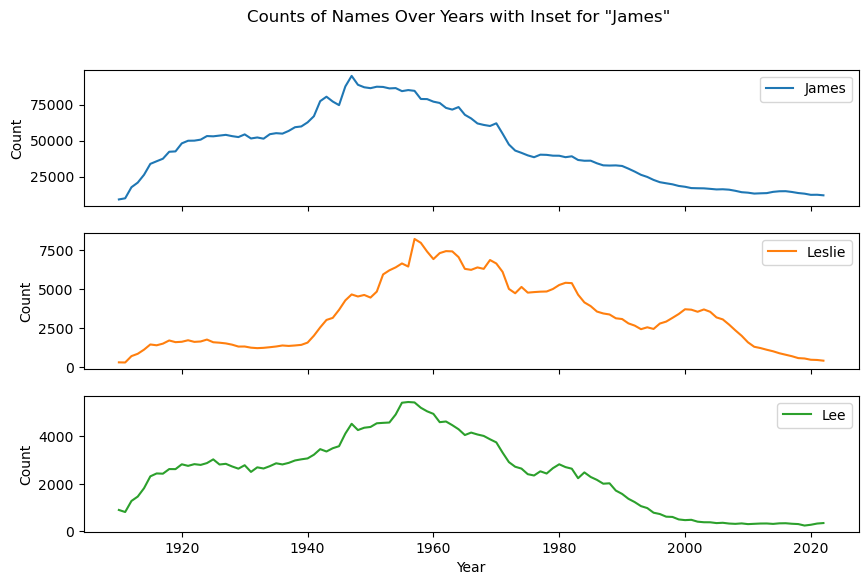

In [30]:

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Sample DataFrames (replace with your actual DataFrames)
df_name1 = James 

df_name2 = Leslie
df_name3 = Lee 

# List of DataFrames and names
dfs = [df_name1, df_name2, df_name3]
names = ['James', 'Leslie', 'Lee']

# Create subplots
fig, axes = plt.subplots(len(dfs), 1, sharex=True, figsize=(10, 2*len(dfs)))

# Plot data for each name
for i, (df, name) in enumerate(zip(dfs, names)):
    axes[i].plot(df['Year'], df['Count'], label=name, color='C'+str(i))
    axes[i].set_ylabel('Count')

    # Find the peak year for 'James'
    peak_year = df[df['Count'] == df['Count'].max()]['Year'].values[0]



    axes[i].legend()

# Set x-axis label
axes[-1].set_xlabel('Year')

plt.suptitle('Counts of Names Over Years with Inset for "James"')
plt.show()

## Excercise 1

Use the code you wrote last week in that Excercise 1 to create a function `plot_three_names` that takes in three arbitrary names and generates the same stacked subplot figure we previously made for James, Leslie, and Lee.

**Hint: see if you can use `generate_name_df()` function inside your `plot_three_names` function to simplify the proccess of creating the individual name dataframes**

In [ ]:
...
name1, name2, name3 = 'Anna', 'John', 'Robert'
plot_three_names(name1,name2,name3)